# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [68]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand
from pyspark.sql.functions import min as fmin,count
from pyspark.sql.functions import isnan, when, count, col,desc
from pyspark.sql.functions import max as fmax
from pyspark.sql.types import *

import re
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [69]:
# create a Spark session
spark= SparkSession.builder.appName('spakifyDsProject').getOrCreate()

# Load Data

In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [70]:
#Load data using spark
df=spark.read.json('mini_sparkify_event_data.json')

In [71]:
#look at the first record
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [72]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [73]:
#Create a tempview to write SQL query for data analysis

df.createOrReplaceTempView('sparkify_table')

In [74]:
spark.sql(''' select * from sparkify_table limit 5''').toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [75]:
#find Unique no of user IDs
spark.sql('''

select count(distinct userId) as uniqueUserId from sparkify_table where userId is not null ''').show()

+------------+
|uniqueUserId|
+------------+
|         226|
+------------+



In [76]:
#Find out distribution of gender
gender_dist=spark.sql('''

select gender,count(distinct userId) as user_count from sparkify_table 
group by gender''')

gender_dist.show()

+------+----------+
|gender|user_count|
+------+----------+
|     F|       104|
|  null|         1|
|     M|       121|
+------+----------+



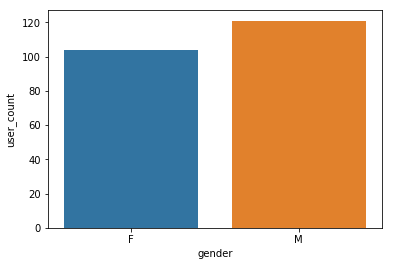

In [77]:
sns.barplot(x='gender',y='user_count',data=gender_dist.toPandas())

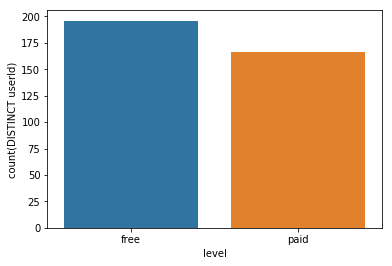

In [78]:
#Find out distribution of level

subscription_dist=spark.sql('''

select level,count(distinct userId) from sparkify_table 
group by level''')

sns.barplot(x='level',y='count(DISTINCT userId)',data=subscription_dist.toPandas())

In [79]:
#Find out the number of song user listened
spark.sql('''

select userId,count(song) as song_count  from sparkify_table where page='NextSong'
group by userId order by song_count desc''').show()

+------+----------+
|userId|song_count|
+------+----------+
|    39|      8002|
|    92|      5945|
|   140|      5664|
|300011|      4619|
|   124|      4079|
|300021|      3816|
|300017|      3632|
|    85|      3616|
|    42|      3573|
|     6|      3159|
|    29|      3028|
|200023|      2955|
|    54|      2841|
|   100|      2682|
|     9|      2676|
|    91|      2580|
|   126|      2577|
|300015|      2524|
|    98|      2401|
|    74|      2400|
+------+----------+
only showing top 20 rows



In [80]:
#find out distribution of page visits by users
spark.sql('''

select page,count(userId) as user_count  from sparkify_table 
group by page order by user_count desc''').show()

+--------------------+----------+
|                page|user_count|
+--------------------+----------+
|            NextSong|    228108|
|                Home|     14457|
|           Thumbs Up|     12551|
|     Add to Playlist|      6526|
|          Add Friend|      4277|
|         Roll Advert|      3933|
|               Login|      3241|
|              Logout|      3226|
|         Thumbs Down|      2546|
|           Downgrade|      2055|
|                Help|      1726|
|            Settings|      1514|
|               About|       924|
|             Upgrade|       499|
|       Save Settings|       310|
|               Error|       258|
|      Submit Upgrade|       159|
|    Submit Downgrade|        63|
|              Cancel|        52|
|Cancellation Conf...|        52|
+--------------------+----------+
only showing top 20 rows



Text(0.5,1,'Event Distribution')

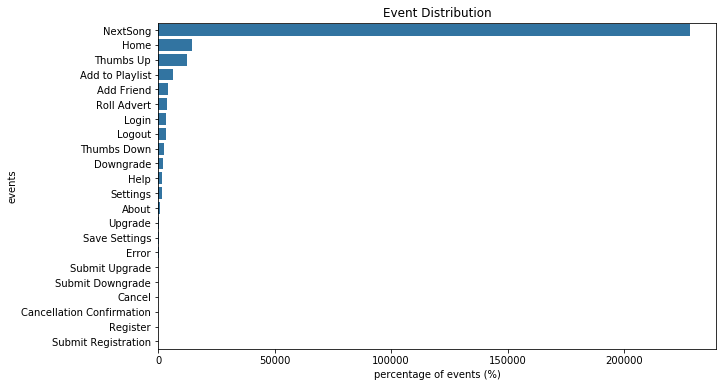

In [81]:
#plot diagram

events_df = df.groupby('page').count().orderBy('count', ascending=False).toPandas()
plt.figure(figsize=(10,6))
sns.barplot(y=events_df.page, x=events_df['count'], color=sns.color_palette()[0])
plt.xlabel('percentage of events (%)')
plt.ylabel('events')
plt.title('Event Distribution')

In [82]:
#Analyse submit downgrade page event

df.where((df.page =='Submit Downgrade') | (df.page =='Submit Downgrade') |
         (df.page =='Cancel')|(df.page =='Cancellation Confirmation')).select('userId').distinct().count()

92

In [83]:
df.select('itemInSession').describe().show()

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            286500|
|   mean|114.41421291448516|
| stddev|129.76726201140994|
|    min|                 0|
|    max|              1321|
+-------+------------------+



In [84]:
df.select(['auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'level', 'location']).describe().show()

+-------+----------+---------+------+------------------+--------+-----------------+------+-----------------+
|summary|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|
+-------+----------+---------+------+------------------+--------+-----------------+------+-----------------+
|  count|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|
|   mean|      null|     null|  null|114.41421291448516|    null|249.1171819778458|  null|             null|
| stddev|      null|     null|  null|129.76726201140994|    null|99.23517921058361|  null|             null|
|    min| Cancelled| Adelaida|     F|                 0|   Adams|          0.78322|  free|       Albany, OR|
|    max|Logged Out|   Zyonna|     M|              1321|  Wright|       3024.66567|  paid|Winston-Salem, NC|
+-------+----------+---------+------+------------------+--------+-----------------+------+-----------------+



## Clean Data

In [85]:
#find null values in each column
# source: https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


In [86]:
# find empty strings in dataframe
df.select([count(when(col(c) == '', c)).alias(c) for c in df.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8346


lets look at the data where userId is empty

In [87]:
df.where(df['userId']=='').toPandas()[:10]

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged Out,None,None,100,None,None,free,None,GET,Home,None,8,None,200,1538355745000,None,
1,None,Logged Out,None,None,101,None,None,free,None,GET,Help,None,8,None,200,1538355807000,None,
2,None,Logged Out,None,None,102,None,None,free,None,GET,Home,None,8,None,200,1538355841000,None,
3,None,Logged Out,None,None,103,None,None,free,None,PUT,Login,None,8,None,307,1538355842000,None,
4,None,Logged Out,None,None,2,None,None,free,None,GET,Home,None,240,None,200,1538356678000,None,
5,None,Logged Out,None,None,3,None,None,free,None,PUT,Login,None,240,None,307,1538356679000,None,
6,None,Logged Out,None,None,0,None,None,free,None,PUT,Login,None,100,None,307,1538358102000,None,
7,None,Logged Out,None,None,0,None,None,free,None,PUT,Login,None,241,None,307,1538360117000,None,
8,None,Logged Out,None,None,14,None,None,free,None,GET,Home,None,187,None,200,1538361527000,None,
9,None,Logged Out,None,None,15,None,None,free,None,PUT,Login,None,187,None,307,1538361528000,None,


In [88]:
df.select('artist').where(df['userId']=='').distinct().show()

+------+
|artist|
+------+
|  null|
+------+



In [89]:
df.select('song').where(df['userId']=='').distinct().show()

+----+
|song|
+----+
|null|
+----+



In [90]:
df.select('page').where(df['userId']=='').distinct().show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



In [91]:
df.where(df['userId']=='').groupby('page').count().sort('count').show()

+-------------------+-----+
|               page|count|
+-------------------+-----+
|Submit Registration|    5|
|              Error|    6|
|           Register|   18|
|               Help|  272|
|              About|  429|
|              Login| 3241|
|               Home| 4375|
+-------------------+-----+



In [92]:
df_cleaned=df.filter((df.userId!='') & (df.userId.isNotNull()) & (~ isnan(df.userId)))

In [93]:
# find empty strings in dataframe
df_cleaned.select([count(when(col(c) == '', c)).alias(c) for c in df_cleaned.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [94]:
#find null values in each column
# source: https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe
df_cleaned.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_cleaned.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,50046,0,0,0,0,0,50046,0,0,0,0,0,0,50046,0,0,0,0


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcfe4de7588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fcff90f7710>]], dtype=object)

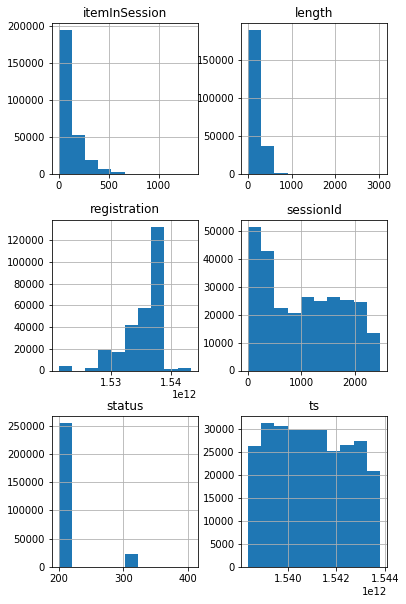

In [95]:
fig = plt.figure(figsize = (6,10))
ax = fig.gca()
df_cleaned.toPandas().hist(ax = ax)

In [96]:
#get_hour=udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).hour)
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%m-%d-%Y %H:%M:%S"))
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)

In [97]:
df_cleaned=df_cleaned.withColumn('Time', get_time(df.ts))
df_cleaned=df_cleaned.withColumn('Hour', get_hour(df.ts))
df_cleaned=df_cleaned.withColumn('Day', get_day(df.ts))
df_cleaned=df_cleaned.withColumn('Month', get_month(df.ts))

In [98]:
df_cleaned.toPandas()[-10:]

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,sessionId,song,status,ts,userAgent,userId,Time,Hour,Day,Month
278144,The Rolling Stones,Logged In,Emilia,F,33,House,225.30567,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,...,500,Tops,200,1543620971000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011,11-30-2018 23:36:11,23,30,11
278145,Alejandro Sanz,Logged In,Emilia,F,34,House,241.52771,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,...,500,Tu no tienes alma,200,1543621196000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011,11-30-2018 23:39:56,23,30,11
278146,Valley of the Giants,Logged In,Emilia,F,35,House,420.46649,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,...,500,Bala Bay Inn,200,1543621437000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011,11-30-2018 23:43:57,23,30,11
278147,None,Logged In,Emilia,F,36,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,...,500,None,200,1543621485000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011,11-30-2018 23:44:45,23,30,11
278148,Olive,Logged In,Emilia,F,37,House,264.12363,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,...,500,You're Not Alone,200,1543621857000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011,11-30-2018 23:50:57,23,30,11
278149,Iron Maiden,Logged In,Emilia,F,38,House,258.66404,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,...,500,Murders In The Rue Morgue (1998 Digital Remaster),200,1543622121000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011,11-30-2018 23:55:21,23,30,11
278150,None,Logged In,Emilia,F,39,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,...,500,None,307,1543622122000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011,11-30-2018 23:55:22,23,30,11
278151,None,Logged In,Emilia,F,43,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,...,500,None,200,1543622248000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011,11-30-2018 23:57:28,23,30,11
278152,None,Logged In,Emilia,F,44,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,...,500,None,200,1543622398000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011,11-30-2018 23:59:58,23,30,11
278153,Camera Obscura,Logged In,Emilia,F,45,House,170.89261,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,...,500,The Sun On His Back,200,1543622411000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011,12-01-2018 00:00:11,0,1,12


In [99]:
df_cleaned['userAgent']

Column<b'userAgent'>

In [100]:
spark.sql('''

select page,count(userId) as user_count  from cleaned_table 
group by page order by user_count desc''').show()

+--------------------+----------+
|                page|user_count|
+--------------------+----------+
|            NextSong|    228108|
|           Thumbs Up|     12551|
|                Home|     10082|
|     Add to Playlist|      6526|
|          Add Friend|      4277|
|         Roll Advert|      3933|
|              Logout|      3226|
|         Thumbs Down|      2546|
|           Downgrade|      2055|
|            Settings|      1514|
|                Help|      1454|
|             Upgrade|       499|
|               About|       495|
|       Save Settings|       310|
|               Error|       252|
|      Submit Upgrade|       159|
|    Submit Downgrade|        63|
|              Cancel|        52|
|Cancellation Conf...|        52|
+--------------------+----------+



In [101]:
# Extract the state fromlocation
def get_state(location):
    location = location.split(',')[-1].strip()
    if (len(location) > 2):
        location = location.split('-')[-1].strip()

    return location
    
get_state = udf(get_state, StringType())
df_cleaned = df_cleaned.withColumn('state', get_state(col('location')))

In [102]:
df_cleaned.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Time='10-01-2018 00:01:57', Hour='0', Day='1', Month='10', state='CA')]

In [103]:
df_cleaned.select(['userId','auth', 'gender', 'state','level','Month', 'day', 'hour']).where((df.page=='Submit Downgrade')  ).toPandas()

,userId,auth,gender,state,level,Month,day,hour
0,131,Logged In,M,VA,paid,10,1,11
1,38,Logged In,M,PA,paid,10,2,21
2,141,Logged In,F,UT,paid,10,6,14
3,30,Logged In,M,CA,paid,10,8,10
4,20,Logged In,F,FL,paid,10,8,11
5,12,Logged In,F,CA,paid,10,10,4
6,11,Logged In,F,MA,paid,10,11,6
7,61,Logged In,M,CA,paid,10,11,7
8,81,Logged In,M,MD,paid,10,11,13
9,85,Logged In,M,CA,paid,10,12,9


In [104]:
df_cleaned.select(['userId','auth', 'gender', 'level','Month', 'day', 'hour']).where(df_cleaned.userId==131).toPandas()

,userId,auth,gender,level,Month,day,hour
0,131,Logged In,M,free,10,1,8
1,131,Logged In,M,free,10,1,9
2,131,Logged In,M,free,10,1,9
3,131,Logged In,M,free,10,1,9
4,131,Logged In,M,free,10,1,9
5,131,Logged In,M,free,10,1,9
6,131,Logged In,M,free,10,1,9
7,131,Logged In,M,free,10,1,9
8,131,Logged In,M,free,10,1,9
9,131,Logged In,M,free,10,1,9


In [105]:
df_cleaned.groupby('page').count().orderBy('count', ascending=False).toPandas()

,page,count
0,NextSong,228108
1,Thumbs Up,12551
2,Home,10082
3,Add to Playlist,6526
4,Add Friend,4277
5,Roll Advert,3933
6,Logout,3226
7,Thumbs Down,2546
8,Downgrade,2055
9,Settings,1514


## Define Churn

In [106]:
df_cleaned.select(['userId','page','auth', 'gender', 'level','Month', 'day', 'hour']) \
            .where((df_cleaned.page=='Cancellation Confirmation')|(df_cleaned.page=='Submit Downgrade')  ).orderBy('userId').toPandas()

,userId,page,auth,gender,level,Month,day,hour
0,100,Submit Downgrade,Logged In,M,paid,11,4,21
1,100001,Cancellation Confirmation,Cancelled,F,free,10,2,16
2,100003,Cancellation Confirmation,Cancelled,F,free,10,11,16
3,100004,Submit Downgrade,Logged In,F,paid,10,18,13
4,100004,Submit Downgrade,Logged In,F,paid,10,31,8
5,100005,Cancellation Confirmation,Cancelled,M,free,10,19,17
6,100006,Cancellation Confirmation,Cancelled,F,free,10,5,15
7,100007,Cancellation Confirmation,Cancelled,F,paid,11,29,11
8,100008,Submit Downgrade,Logged In,F,paid,11,20,21
9,100009,Submit Downgrade,Logged In,M,paid,10,21,12


In [107]:
get_churn= udf(lambda x :1 if (x=='Cancellation Confirmation') else 0, IntegerType())

df_cleaned=df_cleaned.withColumn('churn',get_churn('page') )

In [108]:
df_cleaned.createOrReplaceTempView('cleaned_table')

In [109]:
spark.sql('''

select churn,count( distinct userId) from cleaned_table where churn=1 group by churn 

''').show()


+-----+----------------------+
|churn|count(DISTINCT userId)|
+-----+----------------------+
|    1|                    52|
+-----+----------------------+



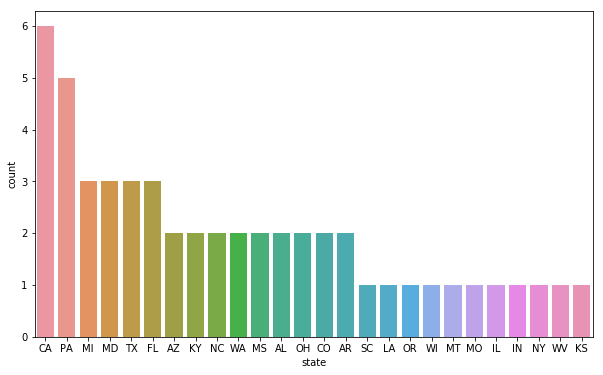

In [110]:
df_churn_state=df_cleaned.filter('churn==1').groupby('state').count().orderBy('count',ascending=False).toPandas()
plt.figure(figsize=(10,6))
sns.barplot(x='state' ,y='count', data=df_churn_state)

Text(0.5,1,'Event Distribution')

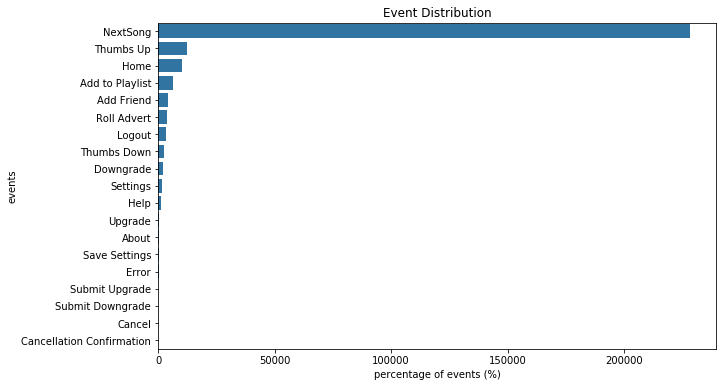

In [111]:
events_df = df_cleaned.groupby('page').count().orderBy('count', ascending=False).toPandas()
plt.figure(figsize=(10,6))
sns.barplot(y=events_df.page, x=events_df['count'], color=sns.color_palette()[0])
plt.xlabel('percentage of events (%)')
plt.ylabel('events')
plt.title('Event Distribution')

##### Now lets look at the chrurn d

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [112]:
df_cleaned.select('userId', 'gender').dropDuplicates(subset=['userId']).\
    replace(['F', 'M'], ['0', '1'], 'gender').select('userId', col('gender').cast('int')).show()

+------+------+
|userId|gender|
+------+------+
|100010|     0|
|200002|     1|
|   125|     1|
|   124|     0|
|    51|     1|
|     7|     1|
|    15|     1|
|    54|     0|
|   155|     0|
|100014|     1|
|   132|     0|
|   154|     0|
|   101|     1|
|    11|     0|
|   138|     1|
|300017|     0|
|100021|     1|
|    29|     1|
|    69|     0|
|   112|     1|
+------+------+
only showing top 20 rows



In [113]:
def add_feature(df):
    
    
    # Add downgraded column
    is_downgraded = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())
    df = df.withColumn('is_downgraded', is_downgraded(df.page))

    df_downgraded = df.select('userId', 'is_downgraded').sort('is_downgraded', ascending=False).dropDuplicates(subset=['userId'])
    
    # Number of help requests
    df_help_req = df.select('userID','page').filter('page == "Help"')\
    .groupBy('userID').count().withColumnRenamed('count', 'help_requests')
    # Add churn label
    df_churn = df.select('userId', 'churn').sort('churn', ascending=False).dropDuplicates(subset=['userId'])
    
    # Add gender feature
    df_gender = df.select('userId', 'gender').dropDuplicates(subset=['userId']).\
    replace(['F', 'M'], ['0', '1'], 'gender').select('userId', col('gender').cast('int'))
    
    # Add Subscription_level feature
    df_subscription_level = df.select('userId', 'level').dropDuplicates(subset=['userId']).\
    replace(['free', 'paid'], ['0', '1'], 'level').select('userId', col('level').cast('int'))
    
    # Time Spent listening feature
    df_time_spent = df.select('userID','length').groupBy('userID').sum().withColumnRenamed('sum(length)', 'time_spent')
    
    # Number of friends added
    df_friends = df.select('userID','page').filter('page == "Add Friend"')\
    .groupBy('userID').count().withColumnRenamed('count', 'added_friends')
    
    
     #Number of playlist songs
    df_song = df.select('userID','page').filter('page == "Add to Playlist"')\
    .groupBy('userID').count().withColumnRenamed('count', 'songs_playlisted')
    
   
    # Join features and labels into new dataframe

    ml_df = df_gender.join(df_subscription_level, on='userId', how='outer')\
               .join(df_time_spent, on='userId', how='outer')\
               .join(df_friends, on='userId', how='outer')\
               .join(df_song, on='userId', how='outer')\
               .join(df_help_req, on='userId', how='outer')\
               .join(df_downgraded, on='userId', how='outer')\
               .join(df_churn, on='userId', how='outer')\
               .fillna(0)
    
    return ml_df

In [114]:
ml_df=add_feature(df_cleaned)

ml_df.toPandas()

,userId,gender,level,time_spent,added_friends,songs_playlisted,help_requests,is_downgraded,churn
0,100010,0,0,6.694090e+04,4,7,2,0,0
1,200002,1,0,9.400888e+04,4,8,2,0,0
2,125,1,0,2.089113e+03,0,0,0,0,1
3,124,0,1,1.012312e+06,74,118,23,0,0
4,51,1,1,5.232758e+05,28,52,12,0,1
5,7,1,0,3.803409e+04,1,5,1,0,0
6,15,1,1,4.773076e+05,31,59,8,0,0
7,54,0,1,7.113449e+05,33,72,17,1,1
8,155,0,0,1.987793e+05,11,24,9,0,0
9,100014,1,1,6.770347e+04,6,7,2,0,1


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [115]:
# Change features into a dense vector
vect_assembler = VectorAssembler(inputCols=['gender','level','time_spent','added_friends',
                                         'songs_playlisted','help_requests','is_downgraded'],
                              outputCol="features")
assembler_df = vect_assembler.transform(ml_df)

assembler_df.show()

+------+------+-----+------------------+-------------+----------------+-------------+-------------+-----+--------------------+
|userId|gender|level|        time_spent|added_friends|songs_playlisted|help_requests|is_downgraded|churn|            features|
+------+------+-----+------------------+-------------+----------------+-------------+-------------+-----+--------------------+
|100010|     0|    0| 66940.89735000003|            4|               7|            2|            0|    0|[0.0,0.0,66940.89...|
|200002|     1|    0| 94008.87593999993|            4|               8|            2|            0|    0|[1.0,0.0,94008.87...|
|   125|     1|    0|2089.1131000000005|            0|               0|            0|            0|    1|(7,[0,2],[1.0,208...|
|   124|     0|    1|1012312.0927899999|           74|             118|           23|            0|    0|[0.0,1.0,1012312....|
|    51|     1|    1| 523275.8428000004|           28|              52|           12|            0|    1|[1.0,1

In [116]:
data_df=assembler_df.select('features','churn')
data_df=data_df.withColumnRenamed('churn','label')

data_df.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,0.0,66940.89...|    0|
|[1.0,0.0,94008.87...|    0|
|(7,[0,2],[1.0,208...|    1|
|[0.0,1.0,1012312....|    0|
|[1.0,1.0,523275.8...|    1|
|[1.0,0.0,38034.08...|    0|
|[1.0,1.0,477307.6...|    0|
|[0.0,1.0,711344.9...|    1|
|[0.0,0.0,198779.2...|    0|
|[1.0,1.0,67703.47...|    1|
|[0.0,0.0,483118.9...|    0|
|[0.0,0.0,20660.02...|    0|
|[1.0,0.0,447464.0...|    1|
|[0.0,0.0,159669.9...|    0|
|[1.0,0.0,512449.8...|    0|
|[0.0,1.0,897406.9...|    0|
|[1.0,0.0,57633.17...|    1|
|[1.0,0.0,754517.5...|    1|
|[0.0,0.0,286064.0...|    0|
|[1.0,0.0,53062.74...|    0|
+--------------------+-----+
only showing top 20 rows



In [117]:
train, test = data_df.randomSplit([0.8, 0.2], seed=0)

In [118]:
rf_clf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
rf_model = rf_clf.fit(train)

#Evaluate Performance on Test Data
rf_model_predictions = rf_model.transform(test)


rf_evaluator = MulticlassClassificationEvaluator(metricName='f1')
rf_f1 = rf_evaluator.evaluate(rf_model_predictions)
print(f'The F1-Score value of RandomForestClassifier Model is {rf_f1}')

The F1-Score value of RandomForestClassifier Model is 0.8238297872340425


In [119]:
lr_clf = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")
lr_model = lr_clf.fit(train)

#Evaluate Performance on Test Data
lr_model_predictions = lr_model.transform(test)


lr_evaluator = MulticlassClassificationEvaluator(metricName='f1')
lr_f1 = lr_evaluator.evaluate(lr_model_predictions)
print(f'The F1-Score value of Logistic regression classifier Model is {lr_f1}')

The F1-Score value of Logistic regression classifier Model is 0.8238297872340425


In [120]:
gbt_clf = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)
gbt_model = gbt_clf.fit(train)

#Evaluate Performance on Test Data
gbt_model_predictions = gbt_model.transform(test)


gbt_evaluator = MulticlassClassificationEvaluator(metricName='f1')
gbt_f1 = gbt_evaluator.evaluate(gbt_model_predictions)
print(f'The F1-Score value of GBT classifier Model is {gbt_f1}')

The F1-Score value of GBT classifier Model is 0.8000000000000002


In [121]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr_clf.maxIter, [10, 50, 100]) \
    .addGrid(lr_clf.regParam, [.3,.4]) \
    .addGrid(lr_clf.elasticNetParam, [.8,.9])\
    .build()

In [122]:
cv = CrossValidator(estimator=lr_clf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator())

In [123]:

# perform cross validation

cvModel = cv.fit(train)
bestModel = cvModel.bestModel

In [124]:
## Credit https://stackoverflow.com/questions/51230726/extract-results-from-crossvalidator-with-paramgrid-in-pyspark

# get the results of cross validation

# get parameters
params = [{p.name: v for p, v in m.items()} for m in cvModel.getEstimatorParamMaps()]

# convert validation results to pandas dataframe
validation_results = pd.DataFrame.from_dict([
    {cvModel.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, cvModel.avgMetrics)
])

## Credit https://stackoverflow.com/questions/51230726/extract-results-from-crossvalidator-with-paramgrid-in-pyspark

In [125]:
validation_results

,elasticNetParam,f1,maxIter,regParam
0,0.8,0.628443,10,0.3
1,0.9,0.628443,10,0.3
2,0.8,0.628443,10,0.4
3,0.9,0.628443,10,0.4
4,0.8,0.628443,50,0.3
5,0.9,0.628443,50,0.3
6,0.8,0.628443,50,0.4
7,0.9,0.628443,50,0.4
8,0.8,0.628443,100,0.3
9,0.9,0.628443,100,0.3


In [126]:
tuned_lr_clf = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")
lr_model = tuned_lr_clf.fit(train)

#Evaluate Performance on Test Data
lr_model_predictions = lr_model.transform(test)


lr_evaluator = MulticlassClassificationEvaluator(metricName='f1')
lr_f1 = lr_evaluator.evaluate(lr_model_predictions)
print(f'The F1-Score value of Logistic regression classifier Model is {lr_f1}')

The F1-Score value of Logistic regression classifier Model is 0.8238297872340425


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.